# Simpel AMPL implementation of IV Extrapolation approach

In [219]:
# Google Colab & Kaggle integration
from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["highs"], # modules to install
    license_uuid="default") # license to use

Please provide a valid license UUID. You can use a free https://ampl.com/ce license.


# Diet Model

Problem: minimize linear mapping over parameters $(\theta_0, \theta_1)$ subject to the constraint that parameters also give identified parameters.

Sets:
- `THETA`: Parameter space.
- `THETA0`: parameter space of the model for $m_0$
- `THETA1`: parameter space of the model for $m_1$
- `IDENTIF`: set of identified IV-like estimands.

Parameters:
- `iv {IDENTIF}`: value of identified IV parameter(s).
- `gamma {THETA}`: $\Gamma^*_{dk}(b_{dk})$ for $d\in\{0,1\}$ and $k=1,\cdots,K_d$ - contribution to objective by each parameter.

Variables:
- `t0 {THETA0}`: value of parameters for $m_0$
- `t1 {THETA1}`: value of parameters for $m_1$

Objective:
- `beta_star`: linear map giving $\overline{\beta}_{fd}^*$: sum over terms in `Gamma`.

Constraints:
- `iv {IV_identified}`: ensure that parameters result in identified IV-like estimands.

The problem is then modeled as follows:

In [220]:
%%ampl_eval
reset;
set NUTR;
set FOOD;

param cost {FOOD} > 0;
param f_min {FOOD} >= 0;
param f_max {j in FOOD} >= f_min[j];

param n_min {NUTR} >= 0;
param n_max {i in NUTR} >= n_min[i];

param amt {NUTR,FOOD} >= 0;

var Buy {j in FOOD} >= f_min[j], <= f_max[j];

minimize Total_Cost:  sum {j in FOOD} cost[j] * Buy[j];

subject to Diet {i in NUTR}:
n_min[i] <= sum {j in FOOD} amt[i,j] * Buy[j] <= n_max[i];

## Prepare `pandas.DataFrame` objects with all the data

In [221]:
import pandas as pd
import numpy as np
food_df = pd.DataFrame(
    [
        ("BEEF", 3.59, 2, 10),
        ("CHK", 2.59, 2, 10),
        ("FISH", 2.29, 2, 10),
        ("HAM", 2.89, 2, 10),
        ("MCH", 1.89, 2, 10),
        ("MTL", 1.99, 2, 10),
        ("SPG", 1.99, 2, 10),
        ("TUR", 2.49, 2, 10),
    ],
    columns=["FOOD", "cost", "f_min", "f_max"],
).set_index("FOOD")

# Create a pandas.DataFrame with data for n_min, n_max
nutr_df = pd.DataFrame(
    [
        ("A", 700, 20000),
        ("C", 700, 20000),
        ("B1", 700, 20000),
        ("B2", 700, 20000),
        ("NA", 0, 50000),
        ("CAL", 16000, 24000),
    ],
    columns=["NUTR", "n_min", "n_max"],
).set_index("NUTR")

amt_df = pd.DataFrame(
    np.matrix(
        [
            [60, 8, 8, 40, 15, 70, 25, 60],
            [20, 0, 10, 40, 35, 30, 50, 20],
            [10, 20, 15, 35, 15, 15, 25, 15],
            [15, 20, 10, 10, 15, 15, 15, 10],
            [928, 2180, 945, 278, 1182, 896, 1329, 1397],
            [295, 770, 440, 430, 315, 400, 379, 450],
        ]
    ),
    columns=food_df.index.tolist(),
    index=nutr_df.index.tolist(),
)

## Pandas dataframes

Cost, minimum, and maximum amount of each food:



In [222]:
food_df

,cost,f_min,f_max
FOOD,,,
BEEF,3.59,2,10
CHK,2.59,2,10
FISH,2.29,2,10
HAM,2.89,2,10
MCH,1.89,2,10
MTL,1.99,2,10
SPG,1.99,2,10
TUR,2.49,2,10


Minimum and maximum amounts of each nutrient:

In [223]:
nutr_df

,n_min,n_max
NUTR,,
A,700,20000
C,700,20000
B1,700,20000
B2,700,20000
NA,0,50000
CAL,16000,24000


Amount of each nutrient in each food:

In [224]:
amt_df

,BEEF,CHK,FISH,HAM,MCH,MTL,SPG,TUR
A,60,8,8,40,15,70,25,60
C,20,0,10,40,35,30,50,20
B1,10,20,15,35,15,15,25,15
B2,15,20,10,10,15,15,15,10
NA,928,2180,945,278,1182,896,1329,1397
CAL,295,770,440,430,315,400,379,450


## Load the data from the `pandas.DataFrame` objects

In [225]:
# 1. Send the data from "amt_df" to AMPL and initialize the indexing set "FOOD"
ampl.set_data(food_df, "FOOD")
# 2. Send the data from "nutr_df" to AMPL and initialize the indexing set "NUTR"
ampl.set_data(nutr_df, "NUTR")
# 3. Set the values for the parameter "amt" using "amt_df"
ampl.get_parameter("amt").set_values(amt_df)

# Solve with HiGHS

In [226]:
# Specify the solver to use (e.g., HiGHS)
ampl.option["solver"] = "highs"
# Solve
ampl.solve()
# Stop if the model was not solved
assert ampl.get_value("solve_result") == "solved"
# Get objective entity by AMPL name
totalcost = ampl.get_objective('Total_Cost')
# Print it
print("Objective is:", totalcost.value())

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 119.9897589
4 simplex iterations
0 barrier iterations
Objective is: 119.98975893599335


## Reassign data for specific instances and resolve

In [227]:
# Reassign data - specific instances
cost = ampl.get_parameter('cost')
cost.set_values({'BEEF': 5.01, 'HAM': 4.55})
print("Increased costs of beef and ham.")

# Resolve and display objective
ampl.solve()
# Stop if the model was not solved
assert ampl.get_value("solve_result") == "solved"
print("New objective value:", totalcost.value())

Increased costs of beef and ham.
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 144.0120033
0 simplex iterations
0 barrier iterations
New objective value: 144.01200332502077


### Reassign data for all instances and resolve

In [228]:
# Reassign data - all instances
cost.set_values(
    {
        "BEEF": 3,
        "CHK": 5,
        "FISH": 5,
        "HAM": 6,
        "MCH": 1,
        "MTL": 2,
        "SPG": 5.01,
        "TUR": 4.55,
    }
)
print("Updated all costs.")

# Resolve and display objective
ampl.solve()
# Stop if the model was not solved
assert ampl.get_value("solve_result") == "solved"
print("New objective value:", totalcost.value())

Updated all costs.
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 164.10625
4 simplex iterations
0 barrier iterations
New objective value: 164.10625


## Get the values of the variable Buy in a pandas.DataFrame object

In [229]:
df = ampl.get_variable('Buy').get_values().to_pandas()
df

,Buy.val
BEEF,10.000000
CHK,2.000000
FISH,2.000000
HAM,6.851974
MCH,10.000000
MTL,10.000000
SPG,6.765351
TUR,2.000000


## Get the values of an expression into a pandas.DataFrame object

In [230]:
df = ampl.get_data('{j in FOOD} 100*Buy[j]/Buy[j].ub').to_pandas()
df

,100*Buy[j]/(Buy[j].ub)
BEEF,100.000000
CHK,20.000000
FISH,20.000000
HAM,68.519737
MCH,100.000000
MTL,100.000000
SPG,67.653509
TUR,20.000000


The n+1 Bernstein basis polynomials of degree $n$ are defined as 
$$ b_{v,n}(x) = {n\choose v} x^v(1-x)^{n-v} $$
for $v=0, \cdots, n$.

A linear combinations of Bernstein basis polynomoials
$$ B_n(x) = \sum_{v=0}^n\beta_v b_{v,n}(x)$$
is called a Bernstein polynomial.

In [231]:
# Define some of the functions that we need
from math import comb

def bernstein_basis(n, v, x):
    """Bernstein polynomial basis of degree n and index v at point x"""
    return comb(n, v) * x ** v * (1 - x) ** (n - v)

In [232]:
# Weights for target
def w_target_late(d, u, u_lo, u_hi):
    """Target weight w(d,u): LATE(u_lo, u_hi)
    Args:
        d (np.int): value of treatment
        u (np.int): latent probability to get treatment
        u_lo (np.float): lower bound of the LATE
        u_hi (np.float): upper bound of the LATE
    """
    # Return 1 divided by u_hi - u_lo if u_lo < u < u_hi, 0 otherwise
    if u_lo < u < u_hi: w = 1 / (u_hi - u_lo)
    else: w = 0

    if d == 1: return w
    else: return -w

In [233]:
import scipy.integrate as integrate

def gamma_star0_late(m0, weight, u_lo, u_hi):
    """Gamma*0: the first term of the gamma* function for binary IV, no covariates
    Args:
        m0 (function): MTE function for d = 0
        weight (function): weights corresponding to target d = 0
    """
    def func(u): return m0(u) * weight(0, u, u_lo, u_hi)
    return integrate.quad(func, 0, 1)[0]

def gamma_star1_late(m1, weight, u_lo, u_hi):
    """Gamma*0: the first term of the gamma* function for binary IV, no covariates
    Args:
        m1 (function): MTE function for d = 1
        weight (function): weights corresponding to target d = 1
    """
    def func(u): return m1(u) * weight(1, u, u_lo, u_hi)
    return integrate.quad(func, 0, 1)[0]

In [234]:
# Compute the contributions of parameters for gamma_star(basis_function)
def bern_2_0(u): return bernstein_basis(2, 0, u)
def bern_2_1(u): return bernstein_basis(2, 1, u)
def bern_2_2(u): return bernstein_basis(2, 2, u)


In [235]:
gamma_star0_late(bern_2_0, w_target_late, u_lo=0.2, u_hi=0.8)

-0.27999999999985575

In [236]:
gamma_star1_late(bern_2_0, w_target_late, u_lo=0.2, u_hi=0.8)

0.27999999999985575

In [237]:
# Compute the LATEs from the example
def m0_dgp(u): 
    return 0.6 * bern_2_0(u) + 0.4 * bern_2_1(u) + 0.3 * bern_2_2(u)

def m1_dgp(u):
    return 0.75 * bern_2_0(u) + 0.5 * bern_2_1(u) + 0.25 * bern_2_2(u)

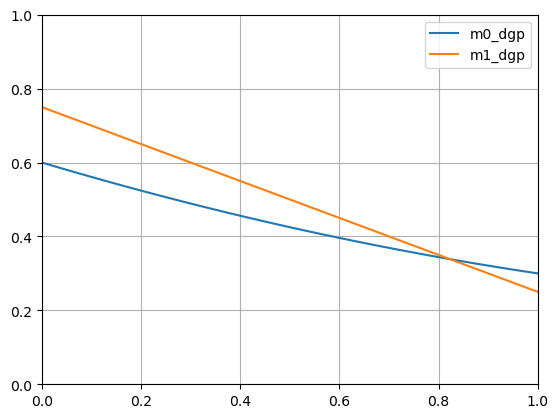

In [238]:
# Plot m0_dgp and m1_dgp over the unit interval
import matplotlib.pyplot as plt
u = np.linspace(0, 1, 100)
plt.plot(u, m0_dgp(u), label='m0_dgp')
plt.plot(u, m1_dgp(u), label='m1_dgp')
plt.grid()
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [239]:
# Compute implied LATE
a = integrate.quad(lambda u: m1_dgp(u) * w_target_late(1, u, 0.35, 0.9), 0, 1)[0]
b = integrate.quad(lambda u: m0_dgp(u) * w_target_late(0, u, 0.35, 0.9), 0, 1)[0]
a + b

0.04591666666666566

# Diet Model

Problem: minimize linear mapping over parameters $(\theta_0, \theta_1)$ subject to the constraint that parameters also give identified parameters.

Sets:
- `THETA`: Parameter space.
- `THETA0`: parameter space of the model for $m_0$
- `THETA1`: parameter space of the model for $m_1$
- `IDENTIF`: set of identified IV-like estimands.

Parameters:
- `iv {IDENTIF}`: value of identified IV parameter(s).
- `gamma {THETA}`: $\Gamma^*_{dk}(b_{dk})$ for $d\in\{0,1\}$ and $k=1,\cdots,K_d$ - contribution to objective by each parameter.

Variables:
- `t0 {THETA0}`: value of parameters for $m_0$
- `t1 {THETA1}`: value of parameters for $m_1$

Objective:
- `beta_star`: linear map giving $\overline{\beta}_{fd}^*$: sum over terms in `Gamma`.

Constraints:
- `iv {IV_identified}`: ensure that parameters result in identified IV-like estimands.

The problem is then modeled as follows:

In [240]:
# Compute the contribution for K_0 = 3 and K_1 = 3
gamma_df = pd.DataFrame(
    [
        ("theta_01", gamma_star0_late(bern_2_0, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_02", gamma_star0_late(bern_2_1, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_03", gamma_star0_late(bern_2_2, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_11", gamma_star1_late(bern_2_0, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_12", gamma_star1_late(bern_2_1, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_13", gamma_star1_late(bern_2_2, w_target_late, u_lo=0.35, u_hi=0.9)),
    ],
    columns=["THETA", "gamma"],
).set_index("THETA")

# Compute the contribution for K_0 = 3 and K_1 = 3
gamma_ident_df = pd.DataFrame(
    [
        ("theta_01", gamma_star0_late(bern_2_0, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_02", gamma_star0_late(bern_2_1, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_03", gamma_star0_late(bern_2_2, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_11", gamma_star1_late(bern_2_0, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_12", gamma_star1_late(bern_2_1, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_13", gamma_star1_late(bern_2_2, w_target_late, u_lo=0.35, u_hi=0.6)),
    ],
    columns=["THETA", "gamma_ident"],
).set_index("THETA")

# Join gamma_df and gamma_ident_df
gamma_df = gamma_df.join(gamma_ident_df)

a = integrate.quad(lambda u: m1_dgp(u) 
    * w_target_late(1, u, 0.35, 0.6), 0, 1)[0]

b = integrate.quad(lambda u: m0_dgp(u) 
    * w_target_late(0, u, 0.35, 0.6), 0, 1)[0]

iv_df = pd.DataFrame(
    [
        ("iv_1", a+b)
    ],
    columns = ["IDENTIF", "iv"]
).set_index("IDENTIF")


In [241]:
iv_df

,iv
IDENTIF,
iv_1,0.079417


In [242]:
%%ampl_eval
reset;
set THETA;
set IDENTIF;

param gamma {THETA};
param gamma_ident {THETA};
param iv {IDENTIF};

var Theta_val {j in THETA} >= 0, <= 1;

maximize beta: sum {j in THETA} gamma[j] * Theta_val[j];

subject to Identified {i in IDENTIF}:
sum {j in THETA} gamma_ident[j] * Theta_val[j] == iv[i];


In [243]:
ampl.set_data(gamma_df, "THETA")
ampl.set_data(iv_df, "IDENTIF")

In [244]:
# Specify the solver to use (e.g., HiGHS)
ampl.option["solver"] = "highs"
# Solve
ampl.solve()

# Stop if the model was not solved
assert ampl.get_value("solve_result") == "solved"
# Get objective entity by AMPL name
beta_hi = ampl.get_objective('beta')
# Print it
print("Objective is:", beta_hi.value())
argmax = ampl.get_variable('Theta_val').get_values().to_pandas()
print("argmax:", argmax)

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 0.3608654721
0 simplex iterations
0 barrier iterations
Objective is: 0.3608654721269454
argmax:           Theta_val.val
theta_01       1.000000
theta_02       0.000000
theta_03       0.000000
theta_11       0.000000
theta_12       0.265017
theta_13       1.000000


In [245]:
# Code up constant splines
def cs_basis(u_lo, u_hi, u):
    """Constant spline basis function (no covariates)"""
    if u_lo <= u < u_hi: return 1
    else: return 0

cs_0_35 = lambda u: cs_basis(0, 0.35, u)
cs_35_60 = lambda u: cs_basis(0.35, 0.60, u)
cs_60_90 = lambda u: cs_basis(0.60, 0.90, u)
cs_90_1 = lambda u: cs_basis(0.90, 1, u)

In [246]:
# Repeat for constant spline basis
gamma_df = pd.DataFrame(
    [
        ("theta_0_1", gamma_star0_late(cs_0_35, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_0_2", gamma_star0_late(cs_35_60, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_0_3", gamma_star0_late(cs_60_90, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_0_4", gamma_star0_late(cs_90_1, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_1_1", gamma_star1_late(cs_0_35, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_1_2", gamma_star1_late(cs_35_60, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_1_3", gamma_star1_late(cs_60_90, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_1_4", gamma_star1_late(cs_90_1, w_target_late, u_lo=0.35, u_hi=0.9)),
    ],
    columns=["THETA", "gamma"],
).set_index("THETA")

# Compute the contribution for K_0 = 3 and K_1 = 3
gamma_ident_df = pd.DataFrame(
    [
        ("theta_0_1", gamma_star0_late(cs_0_35, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_0_2", gamma_star0_late(cs_35_60, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_0_3", gamma_star0_late(cs_60_90, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_0_4", gamma_star0_late(cs_90_1, w_target_late, u_lo=0.35, u_hi=0.6)),

        ("theta_1_1", gamma_star1_late(cs_0_35, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_1_2", gamma_star1_late(cs_35_60, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_1_3", gamma_star1_late(cs_60_90, w_target_late, u_lo=0.35, u_hi=0.6)),
        ("theta_1_4", gamma_star1_late(cs_90_1, w_target_late, u_lo=0.35, u_hi=0.6)),
    ],
    columns=["THETA", "gamma_ident"],
).set_index("THETA")




# Join gamma_df and gamma_ident_df
gamma_df = gamma_df.join(gamma_ident_df)

a = integrate.quad(lambda u: m1_dgp(u) 
    * w_target_late(1, u, 0.35, 0.6), 0, 1)[0]

b = integrate.quad(lambda u: m0_dgp(u) 
    * w_target_late(0, u, 0.35, 0.6), 0, 1)[0]

iv_df = pd.DataFrame(
    [
        ("iv_1", a+b)
    ],
    columns = ["IDENTIF", "iv"]
).set_index("IDENTIF")

gamma_df, iv_df


C:\Users\budde\AppData\Local\Temp\ipykernel_8704\3842910436.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func, 0, 1)[0]
C:\Users\budde\AppData\Local\Temp\ipykernel_8704\3842910436.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the

(              gamma  gamma_ident
 THETA                           
 theta_0_1  0.000000          0.0
 theta_0_2 -0.454545         -1.0
 theta_0_3 -0.545455          0.0
 theta_0_4  0.000000          0.0
 theta_1_1  0.000000          0.0
 theta_1_2  0.454545          1.0
 theta_1_3  0.545455          0.0
 theta_1_4  0.000000          0.0,
                iv
 IDENTIF          
 iv_1     0.079417)

In [247]:

%%ampl_eval
reset;
set THETA;
set IDENTIF;

param gamma {THETA};
param gamma_ident {THETA};
param iv {IDENTIF};

var Theta_val {j in THETA} >= 0, <= 1;

maximize beta: sum {j in THETA} gamma[j] * Theta_val[j];

subject to Identified {i in IDENTIF}:
sum {j in THETA} gamma_ident[j] * Theta_val[j] == iv[i];


In [248]:
ampl.set_data(gamma_df, "THETA")
ampl.set_data(iv_df, "IDENTIF")

# Specify the solver to use (e.g., HiGHS)
ampl.option["solver"] = "highs"
# Solve
ampl.solve()

# Stop if the model was not solved
assert ampl.get_value("solve_result") == "solved"
# Get objective entity by AMPL name
beta_hi = ampl.get_objective('beta')
# Print it
print("Objective is:", beta_hi.value())
argmax = ampl.get_variable('Theta_val').get_values().to_pandas()
print("argmax:", argmax)

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 0.5815530303
0 simplex iterations
0 barrier iterations
Objective is: 0.5815530303030305
argmax:            Theta_val.val
theta_0_1       0.000000
theta_0_2       0.000000
theta_0_3       0.000000
theta_0_4       0.000000
theta_1_1       0.000000
theta_1_2       0.079417
theta_1_3       1.000000
theta_1_4       0.000000


In [249]:
# Weights for IV-like estimands
def s_iv_slope(z, exp_z, cov_d_z):
    """IV-like specification s(d,z): IV slope
    Args:
        z (np.int): value of the instrument
        exp_z (np.float): expected value of the instrument
        cov_d_z (np.float): covariance between treatment and instrument
    """
    return (z - exp_z) / cov_d_z

In [250]:
def compute_iv_slope(m1, m0):
    """IV-like specification gamma_0(d,z): IV slope
    Args:
        d (np.int): value of treatment
        z (np.int): value of the instrument
        exp_z (np.float): expected value of the instrument
        cov_d_z (np.float): covariance between treatment and instrument

        z takes 3 values: 0, 1, 2
        P(z=k): 0.5, 0.4, 0.1
        P(d=1|z=k): 0.35, 0.6, 0.7
    """

    exp_z = 0 * 0.5 + 1 * 0.4 + 2 * 0.1
    ed = 0.35 * 0.5 + 0.6 * 0.4 + 0.7 * 0.1
    ez = 0.5 * 0 + 0.4 * 1 + 0.1 * 2
    edz = 0.6 * 0.4 + 2 * 0.7 * 0.1    
    
    cov_d_z = edz - ed * ez

    def check(u): return 1 if u >= 0.35 else 0
    def weight(u): return s_iv_slope(1, 0, exp_z, cov_d_z) * check(u)
    a0 = integrate.quad(lambda u: m1(u) * weight(u), 0, 1)[0]

    def check(u): return 1 if u >= 0.6 else 0
    def weight(u): return s_iv_slope(1, 1, exp_z, cov_d_z) * check(u)
    a1 = integrate.quad(lambda u: m1(u) * weight(u), 0, 1)[0]

    def check(u): return 1 if u >= 0.7 else 0
    def weight(u): return s_iv_slope(1, 2, exp_z, cov_d_z) * check(u)
    a2 = integrate.quad(lambda u: m1(u) * weight(u), 0, 1)[0]

    # Repeat for d = 0
    def check(u): return 1 if u < 0.35 else 0
    def weight(u): return s_iv_slope(0, 0, exp_z, cov_d_z) * check(u)
    b0 = integrate.quad(lambda u: m0(u) * weight(u), 0, 1)[0]

    def check(u): return 1 if u < 0.6 else 0
    def weight(u): return s_iv_slope(0, 1, exp_z, cov_d_z) * check(u)
    b1 = integrate.quad(lambda u: m0(u) * weight(u), 0, 1)[0]

    def check(u): return 1 if u < 0.7 else 0
    def weight(u): return s_iv_slope(0, 2, exp_z, cov_d_z) * check(u)
    b2 = integrate.quad(lambda u: m0(u) * weight(u), 0, 1)[0]

    return a0, a1, a2, b0, b1, b2
    # return 0.5 * (a0 + b0) + 0.4 * (a1 + b1) + 0.1 * (a2 + b2)

In [251]:
def gamma_0_iv_slope(m0, weight, supp_z, f_z, prop_z):

    """
    Args:
        m0 (function): MTE function for d = 0
        weight (function): weights corresponding to IV slope parameter
        supp_z (np.array): support of z
        f_z (np.array): density of z
        prop_z (np.array): propensity score given z
    
    Returns:
        val (float): value of gamma_0 at m0
    """
    # Compute expected value of z
    ez = np.sum(supp_z * f_z)
    ed = np.sum(prop_z * f_z)
    edz = np.sum(supp_z * prop_z * f_z)

    # Compute covariance between d and z
    cov_dz = edz - ed * ez

    # Define function to be integrated over
    def func(u, z): 
        if prop_z[np.where(supp_z == z)[0][0]] < u: return m0(u) * weight(z, ez, cov_dz)
        else : return 0

    # Integrate func over u in [0,1] for every z in supp_z
    return np.sum([integrate.quad(func, 0, 1, args=(z,))[0] * f_z[i] 
         for i, z in enumerate(supp_z)])

def gamma_1_iv_slope(m1, weight, supp_z, f_z, prop_z):

    """
    Args:
        m1 (function): MTE function for d = 1
        weight (function): weights corresponding to IV slope parameter
        supp_z (np.array): support of z
        f_z (np.array): density of z
        prop_z (np.array): propensity score given z
    
    Returns:
        val (float): value of gamma_0 at m1
    """
    # Compute expected value of z
    ez = np.sum(supp_z * f_z)
    ed = np.sum(prop_z * f_z)
    edz = np.sum(supp_z * prop_z * f_z)

    # Compute covariance between d and z
    cov_dz = edz - ed * ez

    # Define function to be integrated over
    def func(u, z): 
        if prop_z[np.where(supp_z == z)[0][0]] > u: return m1(u) * weight(z, ez, cov_dz)
        else : return 0

    # Integrate func over u in [0,1] for every z in supp_z
    return np.sum([integrate.quad(func, 0, 1, args=(z,))[0] * f_z[i] 
         for i, z in enumerate(supp_z)])

In [252]:
# get index of elements in supp_z which are equal to 0
supp_z = np.array([0,1,2])
f_z = np.array([0.5, 0.4, 0.1])
prop_z = np.array([0.35, 0.6, 0.7])

a, b = gamma_0_iv_slope(m0_dgp, s_iv_slope, supp_z, f_z, prop_z), gamma_1_iv_slope(m1_dgp, s_iv_slope, supp_z, f_z, prop_z)
a, b, a+b

(-0.4251001872659388, 0.49873595505617896, 0.07363576779024017)

In [273]:
# Repeat for IV slope coefficient (Figure 2 in the paper)
supp_z = np.array([0,1,2])
f_z = np.array([0.5, 0.4, 0.1])
prop_z = np.array([0.35, 0.6, 0.7])

# Cotribution to target parameter
gamma_df = pd.DataFrame(
    [
        ("theta_0_1", gamma_star0_late(cs_0_35, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_0_2", gamma_star0_late(cs_35_60, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_0_3", gamma_star0_late(cs_60_90, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_0_4", gamma_star0_late(cs_90_1, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_1_1", gamma_star1_late(cs_0_35, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_1_2", gamma_star1_late(cs_35_60, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_1_3", gamma_star1_late(cs_60_90, w_target_late, u_lo=0.35, u_hi=0.9)),
        ("theta_1_4", gamma_star1_late(cs_90_1, w_target_late, u_lo=0.35, u_hi=0.9)),
    ],
    columns=["THETA", "gamma"],
).set_index("THETA")

# Contribution to identified parameter
gamma_ident_df = pd.DataFrame(
    [
        ("theta_0_1", gamma_0_iv_slope(cs_0_35, s_iv_slope, supp_z, f_z, prop_z)),
        ("theta_0_2", gamma_0_iv_slope(cs_35_60, s_iv_slope, supp_z, f_z, prop_z)),
        ("theta_0_3", gamma_0_iv_slope(cs_60_90, s_iv_slope, supp_z, f_z, prop_z)),
        ("theta_0_4", gamma_0_iv_slope(cs_90_1, s_iv_slope, supp_z, f_z, prop_z)),

        ("theta_1_1", gamma_1_iv_slope(cs_0_35, s_iv_slope, supp_z, f_z, prop_z)),
        ("theta_1_2", gamma_1_iv_slope(cs_35_60, s_iv_slope, supp_z, f_z, prop_z)),
        ("theta_1_3", gamma_1_iv_slope(cs_60_90, s_iv_slope, supp_z, f_z, prop_z)),
        ("theta_1_4", gamma_1_iv_slope(cs_90_1, s_iv_slope, supp_z, f_z, prop_z)),
    ],
    columns=["THETA", "gamma_ident"],
).set_index("THETA")

# Join gamma_df and gamma_ident_df
gamma_df = gamma_df.join(gamma_ident_df)

a, b = gamma_0_iv_slope(m0_dgp, s_iv_slope, supp_z, f_z, prop_z), gamma_1_iv_slope(m1_dgp, s_iv_slope, supp_z, f_z, prop_z)

iv_df = pd.DataFrame(
    [
        ("iv_1", a+b)
    ],
    columns = ["IDENTIF", "iv"]
).set_index("IDENTIF")

gamma_df, iv_df


C:\Users\budde\AppData\Local\Temp\ipykernel_8704\3842910436.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func, 0, 1)[0]
C:\Users\budde\AppData\Local\Temp\ipykernel_8704\3842910436.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the

(              gamma   gamma_ident
 THETA                            
 theta_0_1  0.000000  0.000000e+00
 theta_0_2 -0.454545 -8.426966e-01
 theta_0_3 -0.545455 -1.573034e-01
 theta_0_4  0.000000  2.775558e-17
 theta_1_1  0.000000 -3.330669e-16
 theta_1_2  0.454545  8.426966e-01
 theta_1_3  0.545455  1.573034e-01
 theta_1_4  0.000000  0.000000e+00,
                iv
 IDENTIF          
 iv_1     0.073636)

In [254]:
%%ampl_eval
reset;
set THETA;
set IDENTIF;

param gamma {THETA};
param gamma_ident {THETA};
param iv {IDENTIF};

var Theta_val {j in THETA} >= 0, <= 1;

maximize beta: sum {j in THETA} gamma[j] * Theta_val[j];
subject to Identified {i in IDENTIF}:
sum {j in THETA} gamma_ident[j] * Theta_val[j] == iv[i];

In [255]:

ampl.set_data(gamma_df, "THETA")
ampl.set_data(iv_df, "IDENTIF")

# Specify the solver to use (e.g., HiGHS)
ampl.option["solver"] = "highs"
# Solve
ampl.solve()

# Stop if the model was not solved
assert ampl.get_value("solve_result") == "solved"
# Get objective entity by AMPL name
beta_hi = ampl.get_objective('beta')
# Print it
print("Objective is:", beta_hi.value())
argmax = ampl.get_variable('Theta_val').get_values().to_pandas()
print("argmax:", argmax)

HiGHS 1.5.1:   Warning code 1 for call Highs_addRows(lp(), AccConstraints.lb.size(), AccConstraints.lb.data(), AccConstraints.ub.data(), AccConstraints.coeffs.size(), AccConstraints.starts.data(), AccConstraints.indices.data(), AccConstraints.coeffs.data())
HiGHS 1.5.1: optimal solution; objective 0.5003247475
0 simplex iterations
0 barrier iterations
Objective is: 0.5003247474747358
argmax:            Theta_val.val
theta_0_1       0.000000
theta_0_2       0.099286
theta_0_3       0.000000
theta_0_4       0.000000
theta_1_1       0.000000
theta_1_2       0.000000
theta_1_3       1.000000
theta_1_4       0.000000


In [256]:
%%ampl_eval
reset;
set THETA;
set IDENTIF;

param gamma {THETA};
param gamma_ident {THETA};
param iv {IDENTIF};

var Theta_val {j in THETA} >= 0, <= 1;

minimize beta: sum {j in THETA} gamma[j] * Theta_val[j];
subject to Identified {i in IDENTIF}:
sum {j in THETA} gamma_ident[j] * Theta_val[j] == iv[i];

In [257]:

ampl.set_data(gamma_df, "THETA")
ampl.set_data(iv_df, "IDENTIF")

# Specify the solver to use (e.g., HiGHS)
ampl.option["solver"] = "highs"
# Solve
ampl.solve()

# Stop if the model was not solved
assert ampl.get_value("solve_result") == "solved"
# Get objective entity by AMPL name
beta_hi = ampl.get_objective('beta')
# Print it
print("Objective is:", beta_hi.value())
argmax = ampl.get_variable('Theta_val').get_values().to_pandas()
print("argmax:", argmax)

HiGHS 1.5.1:   Warning code 1 for call Highs_addRows(lp(), AccConstraints.lb.size(), AccConstraints.lb.data(), AccConstraints.ub.data(), AccConstraints.coeffs.size(), AccConstraints.starts.data(), AccConstraints.indices.data(), AccConstraints.coeffs.data())
HiGHS 1.5.1: optimal solution; objective -0.4208873737
0 simplex iterations
0 barrier iterations
Objective is: -0.4208873737373858
argmax:            Theta_val.val
theta_0_1       0.000000
theta_0_2       0.000000
theta_0_3       1.000000
theta_0_4       0.000000
theta_1_1       0.000000
theta_1_2       0.274048
theta_1_3       0.000000
theta_1_4       0.000000


In [296]:
d0 = ["theta0_" + str(i) for i in range(4)]
d1 = ["theta1_" + str(i) for i in range(4)]
d = d0 + d1

a = np.zeros(4)
b = np.ones(4)

d, a, b

c = np.concatenate((a, b))
c, d


(array([0., 0., 0., 0., 1., 1., 1., 1.]),
 ['theta0_0',
  'theta0_1',
  'theta0_2',
  'theta0_3',
  'theta1_0',
  'theta1_1',
  'theta1_2',
  'theta1_3'])

In [304]:
df.index.rename("THETA", inplace=True)
df.index.name

'THETA'